Nhận dạng đường chỉ tay sử dụng ***mã hóa Fusion*** và bộ phân lớp ***KNN***.

*   *Mã hóa Fusion*: dùng 4 bộ lọc *Zero DC Gabor* tương ứng với bốn hướng 0, $\frac{\pi}{4}$, $\frac{\pi}{2}$ và $\frac{3\pi}{4}$, sau đó tìm đáp ứng xung lớn nhất trong bốn hướng trên để mã hóa.

In [1]:
%cd /content/drive/My Drive/Notebooks/Projects/Palmprint Recognition/

/content/drive/My Drive/Notebooks/Projects/Palmprint Recognition


In [2]:
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
"""
  Parameters:
    - ksize: Gabor kernel size
    - theta: orientation of four Gabor kernel
    - omega, sigma: Gabor hyper-parameter
"""

ksize = 35
theta = np.array([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4])
omega = 0.0916
sigma = 5.6179

***Đọc dữ liệu:*** Dữ liệu gồm $N = 1301$ ảnh ROI có kích thước *150 x 150* đã được tiền xử lý và lưu dưới dạng các vector có $D = 22500$ chiều, nên ma trận dữ liệu $X$ có kích thước $(1301, 22500)$, và vector nhãn tương ứng $Y$ có kích thước $(1301, 1)$.

In [4]:
fX = open("IITD Palmprint V1/X.csv", "r")
reader = csv.reader(fX)
X = np.array(list(reader)).astype(np.float64)
fX.close()

In [5]:
fY = open("IITD Palmprint V1/Y.csv", "r")
reader = csv.reader(fY)
Y = np.array(list(reader)).astype(np.int64)
fY.close()

***Tạo kernel Gabor***:

*   Hàm Gabor $k(\theta) = \frac{1}{2\pi{\sigma}^2}e^{\frac{-x'^2 - y'^2}{2{\sigma}^2}}(e^{i2{\pi}x'} - e^{-2(\pi\omega\sigma)^2})$
*   $x' = xcos(\theta) + ysin(\theta)$
*   $y' = -xsin(\theta) + ycos(\theta)$

In [6]:
def DCGaborKernel(size, theta, omega, sigma):
  if (size & 1) == 0:
    size += 1

  half = size // 2

  inv2sigma2 = 1 / (2 * sigma * sigma)
  invpi2sigma2 = inv2sigma2 / np.pi

  pi2omega = 2 * np.pi * omega
  cos = np.cos(theta)
  sin = np.sin(theta)

  const = np.exp(-2 * np.pi * omega * sigma * np.pi * omega * sigma)

  kernel = np.zeros((size, size)).astype(np.complex128)

  for i in range(size):
    for j in range(size):
      ii = i - half
      jj = j - half

      x = jj * cos + ii * sin
      y = -jj * sin + ii * cos

      t = pi2omega * x
      
      c = complex(np.cos(t), np.sin(t))

      kernel[i, j] = invpi2sigma2 * np.exp(-(x**2 + y**2) * inv2sigma2) * (c - const)
  
  return kernel

In [7]:
k = np.zeros((4, ksize, ksize)).astype(np.complex128)

k[0] = DCGaborKernel(ksize, theta[0], omega, sigma)
k[1] = DCGaborKernel(ksize, theta[1], omega, sigma)
k[2] = DCGaborKernel(ksize, theta[2], omega, sigma)
k[3] = DCGaborKernel(ksize, theta[3], omega, sigma)

***Mã hóa Fusion***:

*Với mỗi $t$ (tương ứng với bốn hướng của kernel Gabor), tính:*

*   $Real[t] = I(x, y) * k[t].Real$
*   $Imag[t] = I(x, y) * k[t].Imag$
*   $Magn[t] = Real[t] * Imag[t]$

*Với mỗi điểm ảnh [x, y], tính:*

*   $m = argmax \text{ } Magn[t, x, y]$
*   $code[0, x, y] = \text{(I(x, y) is hand region)}$
*   $code[1, x, y] = (Real[m, x, y] \geqslant 0)$
*   $code[2, x, y] = (Imag[m, x, y] \geqslant 0)$

Đặc trưng của ảnh được biểu diễn bởi ma trận nhị phân $code[m, x, y]$ với $m = 0, 1, 2$ (tương ứng với phần mặt nạ, thực, ảo).

In [8]:
def Fusion(img):
  real = np.zeros((4, 50, 50)).astype(np.float64)
  imag = np.zeros((4, 50, 50)).astype(np.float64)
  magn = np.zeros((4, 50, 50)).astype(np.float64)

  real[0] = cv2.filter2D(img, -1, k[0].real)
  imag[0] = cv2.filter2D(img, -1, k[0].imag)
  magn[0] = real[0] * imag[0]

  real[1] = cv2.filter2D(img, -1, k[1].real)
  imag[1] = cv2.filter2D(img, -1, k[1].imag)
  magn[1] = real[1] * imag[1]

  real[2] = cv2.filter2D(img, -1, k[2].real)
  imag[2] = cv2.filter2D(img, -1, k[2].imag)
  magn[2] = real[2] * imag[2]

  real[3] = cv2.filter2D(img, -1, k[3].real)
  imag[3] = cv2.filter2D(img, -1, k[3].imag)
  magn[3] = real[3] * imag[3]

  m = np.argmax(magn, axis = 0)

  code = np.zeros((3, 50, 50)).astype(np.uint8)
  code[0] = img > 5

  for i in range(50):
    for j in range(50):
      amax = m[i, j]
      code[1, i, j] = real[amax, i, j] >= 0
      code[2, i, j] = imag[amax, i, j] >= 0
  
  return code

In [9]:
X_fusion = np.zeros((X.shape[0], 3, 50, 50)).astype(np.uint8)

for i in range(X.shape[0]):
  img = X[i].reshape(150, 150)
  img = cv2.resize(img, (50, 50))
  X_fusion[i] = Fusion(img)

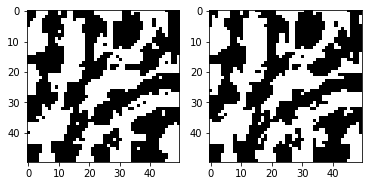

In [10]:
fig, arr = plt.subplots(1, 2)

arr[0].imshow(X_fusion[0][1], cmap = "gray", vmin = 0, vmax = 1)
arr[1].imshow(X_fusion[0][2], cmap = "gray", vmin = 0, vmax = 1)

plt.show()

***Đối sánh***: Dùng khoảng cách Hamming để đối sánh các ma trận nhị phân.

$distance(A, B) = \frac{\sum{((A[0, x, y] \text{ & } B[0, x, y]) \text{ & } ((A[1, x, y] \text{ ^ } B[1, x, y]) \text{ | } (A[2, x, y] \text{ ^ } B[2, x, y])))}}{2\sum{(A[0, x, y] \text{ & } B[0, x, y])}}$

In [11]:
def Distance(codeA, codeB):
  mask = codeA[0] & codeB[0]

  num = np.sum(mask & ((codeA[1] ^ codeB[1]) | (codeA[2] ^ codeB[2])))
  den = 2 * np.sum(mask)

  return num / den

***Tạo tập học và tập kiểm thử:*** tỉ lệ mẫu của hai tập này là *0.85/0.15*.

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_fusion, Y, test_size = 0.15)

In [13]:
class FusionKNN:
  def __init__(self, n_components = 5, metric = None):
    self.n_components = n_components
    self.metric = metric

    self.X_train = None
    self.Y_train = None

  def fit(self, X_train, Y_train):
    self.X_train = X_train
    self.Y_train = Y_train

  def predict(self, X):
    Y_predict = np.zeros((X.shape[0],))

    for i in range(X.shape[0]):
      d = np.zeros((self.X_train.shape[0],))

      for j in range(self.X_train.shape[0]):
        d[j] = self.metric(X[i], self.X_train[j])

      if self.n_components == 1:
        Y_predict[i] = Y_train[np.argmin(d)]
        continue

      order = np.argsort(d)[:self.n_components]
      Y_neighbor = self.Y_train[order]

      count = np.bincount(Y_neighbor)
      Y_predict[i] = np.argmax(count)
    
    return Y_predict

In [14]:
knn = FusionKNN(n_components = 1, metric = Distance)
knn.fit(X_train, Y_train.reshape(-1))

Y_predict = knn.predict(X_test).reshape(-1, 1)

print("Accuracy: {} %".format(np.round(np.mean(Y_predict == Y_test) * 100, 2)))

Accuracy: 92.86 %
